## Pre-steps

### Load libraries

In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# custom preprocessing libraries
from preprocessing import *

# sklearn libraries
from sklearn import svm
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer, OneHotEncoder, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score, StratifiedKFold
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn import metrics


Matplotlib created a temporary cache directory at C:\Users\madio\AppData\Local\Temp\matplotlib-mnif7dtm because the default path (C:\Users\madio\.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [66]:
import warnings
warnings.filterwarnings('ignore')

### Load data

In [3]:
# load preprocessed data
df = pd.read_csv('../data/preprocessed_week_15-05-2024.csv', low_memory = False)
df.head()

df_outlier = pd.read_csv('../data/preprocessed_week_08-05-2024.xlsx', low_memory = False)
# add on-time categories to df_old
df_outlier = add_cat_diff_turnover_time(df_outlier)



## Visualisations


### Visualisation with outliers

Text(0.5, 1.0, 'Distribution of planned turnover-times with categorisation (with outliers)')

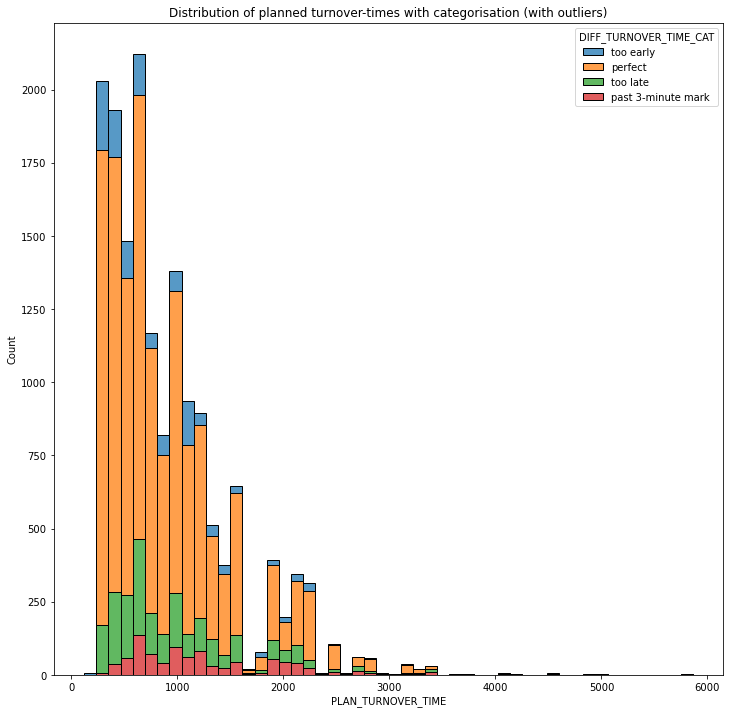

In [4]:
# plot the distribution of the difference in turnover time
hue_order = ['too early', 'perfect', 'too late', 'past 3-minute mark']

plt.figure(figsize=(12, 12))
sns.histplot(df_outlier, x = 'PLAN_TURNOVER_TIME', hue = 'DIFF_TURNOVER_TIME_CAT', hue_order = hue_order ,bins=50, multiple='stack')
plt.title("Distribution of planned turnover-times with categorisation (with outliers)")

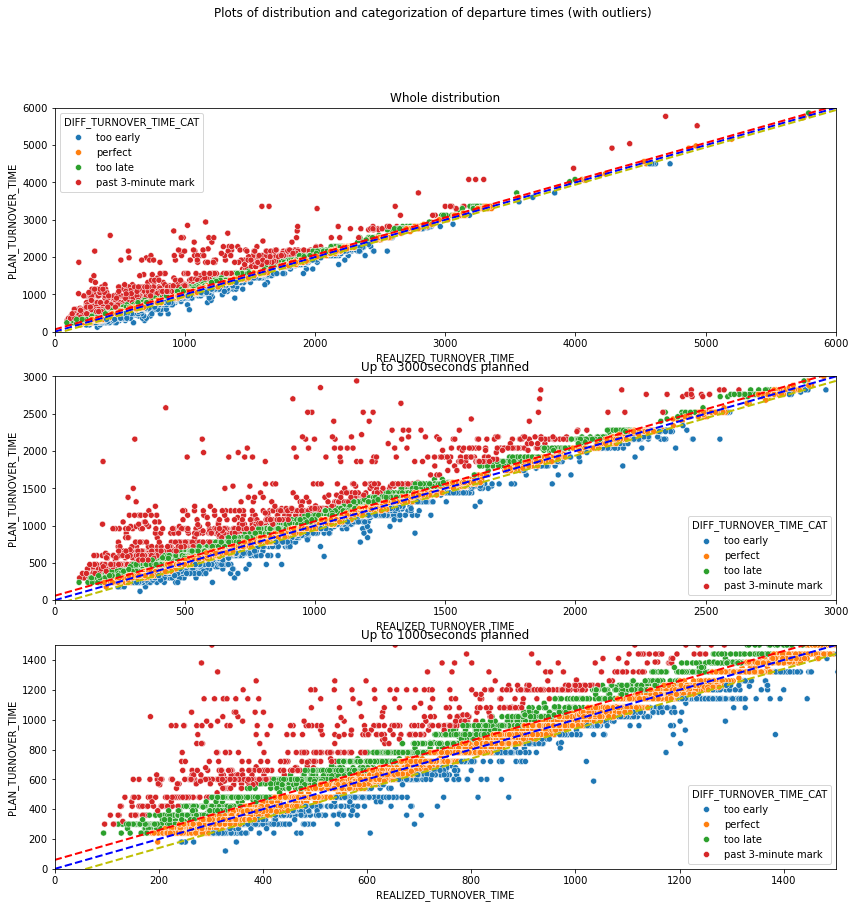

In [5]:
# Plots of Categorization of departure times
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharey = False, figsize=(14,14))
fig.suptitle('Plots of distribution and categorization of departure times (with outliers)')

# distribution of delay on realized_time plot
# whole picture
sns.scatterplot(ax = ax1, data=df_outlier, y='PLAN_TURNOVER_TIME', x='REALIZED_TURNOVER_TIME', hue='DIFF_TURNOVER_TIME_CAT')
ax1.set_title('Whole distribution')
ax1.set_xlim(0, 6000)
ax1.set_ylim(0, 6000)
# zoomed in on 0-3000
sns.scatterplot(ax = ax2, data=df_outlier, y='PLAN_TURNOVER_TIME', x='REALIZED_TURNOVER_TIME', hue='DIFF_TURNOVER_TIME_CAT')
ax2.set_xlim(0, 3000)
ax2.set_ylim(0, 3000)
ax2.set_title('Up to 3000seconds planned')
# zoomed in on 0-1000
sns.scatterplot(ax = ax3, data=df_outlier, y='PLAN_TURNOVER_TIME', x='REALIZED_TURNOVER_TIME', hue='DIFF_TURNOVER_TIME_CAT')
ax3.set_title('Up to 1000seconds planned')
ax3.set_xlim(0, 1500)
ax3.set_ylim(0, 1500)

# loop through plot-axis to draw divider lines
for item in [ax1, ax2, ax3]:
  # Get limits of item x and y axis
  xlim = item.get_xlim()
  ylim = item.get_ylim()

  # Set the limits of x and y axis to be the same to maintain aspect ratio
  lim = (min(xlim[0], ylim[0]), max(xlim[1], ylim[1]))
  # add diagonal line to plot
  lim_minus60 = (min(xlim[0] -60, ylim[0] -60), max(xlim[1] -60, ylim[1] -60))
  lim_plus60 = (min(xlim[0] +60, ylim[0] +60), max(xlim[1] +60, ylim[1] +60))


  # Draw a diagonal line from (min, min) to (max, max)
  item.plot(lim, lim, 'b--', lw=2) 
  item.plot(lim, lim_minus60, 'y--', lw=2) 
  item.plot(lim, lim_plus60, 'r--', lw=2) 

### Visualisation data without outliers



Text(0.5, 1.0, 'Distribution of planned turnover-times with categorisation (without outliers) ')

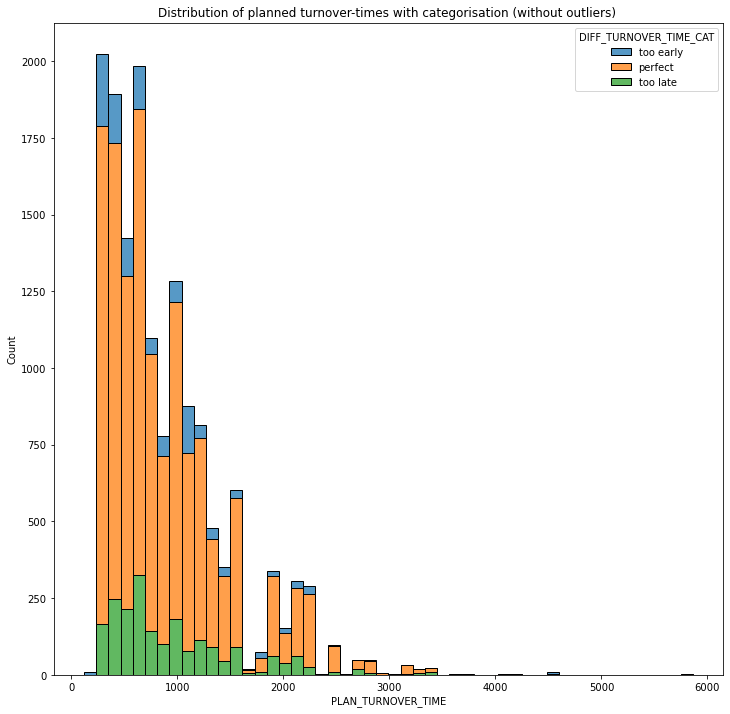

In [6]:
# plot the distribution of the difference in turnover time
plt.figure(figsize=(12, 12))
sns.histplot(df, x = 'PLAN_TURNOVER_TIME', hue = 'DIFF_TURNOVER_TIME_CAT',bins=50, multiple='stack', hue_order = hue_order[0:3] )
plt.title("Distribution of planned turnover-times with categorisation (without outliers) ")

# TODO; this shows that the majority of the realized turnover times are between 0 and 60 seconds of the planned times, which is good.
# TODO; however, it also shows that there are a lot of outliers, which are not good. We should investigate these outliers and see if we can find a pattern in them. -> these outliers are removed in the "data/preprocessed_week_15-05-2024.csv" file. They are visible in "data/preprocessed_week_08-05-2024.xslx"


# todo 3minute mark, another train might go then due to tight train track planning and junction priority to incoming trains -> so if a train is already 3 minutes late, larger change of it being even later

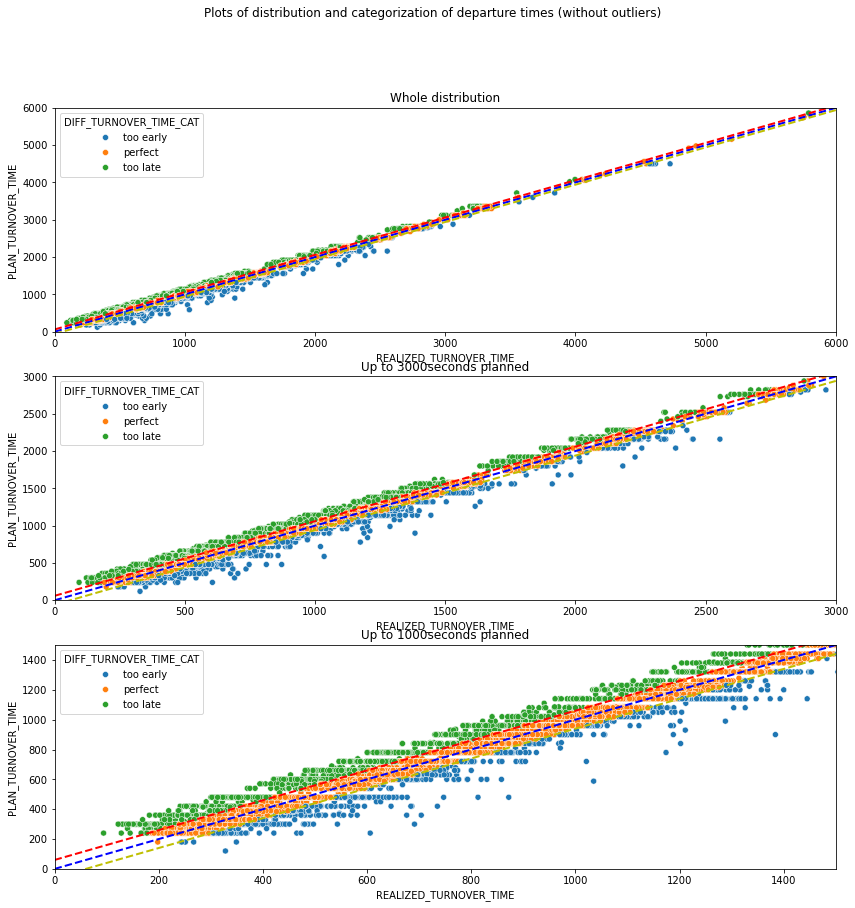

In [7]:
# Plots of Categorization of departure times
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharey = False, figsize=(14,14))
fig.suptitle('Plots of distribution and categorization of departure times (without outliers)')

# distribution of delay on realized_time plot
# whole picture
sns.scatterplot(ax = ax1, data=df, y='PLAN_TURNOVER_TIME', x='REALIZED_TURNOVER_TIME', hue='DIFF_TURNOVER_TIME_CAT', hue_order = hue_order[0:3])
ax1.set_title('Whole distribution')
ax1.set_xlim(0, 6000)
ax1.set_ylim(0, 6000)
# zoomed in on 0-3000
sns.scatterplot(ax = ax2, data=df, y='PLAN_TURNOVER_TIME', x='REALIZED_TURNOVER_TIME', hue='DIFF_TURNOVER_TIME_CAT', hue_order = hue_order[0:3])
ax2.set_xlim(0, 3000)
ax2.set_ylim(0, 3000)
ax2.set_title('Up to 3000seconds planned')
# zoomed in on 0-1000
sns.scatterplot(ax = ax3, data=df, y='PLAN_TURNOVER_TIME', x='REALIZED_TURNOVER_TIME', hue='DIFF_TURNOVER_TIME_CAT', hue_order = hue_order[0:3])
ax3.set_title('Up to 1000seconds planned')
ax3.set_xlim(0, 1500)
ax3.set_ylim(0, 1500)

# loop through plot-axis to draw divider lines
for item in [ax1, ax2, ax3]:
  # Get limits of item x and y axis
  xlim = item.get_xlim()
  ylim = item.get_ylim()

  # Set the limits of x and y axis to be the same to maintain aspect ratio
  lim = (min(xlim[0], ylim[0]), max(xlim[1], ylim[1]))
  # add diagonal line to plot
  lim_minus60 = (min(xlim[0] -60, ylim[0] -60), max(xlim[1] -60, ylim[1] -60))
  lim_plus60 = (min(xlim[0] +60, ylim[0] +60), max(xlim[1] +60, ylim[1] +60))


  # Draw a diagonal line from (min, min) to (max, max)
  item.plot(lim, lim, 'b--', lw=2) 
  item.plot(lim, lim_minus60, 'y--', lw=2) 
  item.plot(lim, lim_plus60, 'r--', lw=2) 

## Support Vector Machine (SVM)
 



## SVC-model


hyperparameters:

kernel:
- Polynomial and RBF are useful for non-linear hyperplane as they compute the separation line in the higher dimension

regularization (C):
- the penalty parameter, which represents misclassification or error term.The misclassification or error term tells the SVM optimization how much error is bearable. This is how you can control the trade-off between decision boundary and misclassification term. A smaller value of C creates a small-margin hyperplane and a larger value of C creates a larger-margin hyperplane.

gamma:
-  A lower value of Gamma will loosely fit the training dataset, whereas a higher value of gamma will exactly fit the training dataset, which causes over-fitting. a low value of gamma considers only nearby points in calculating the separation line, while the a value of gamma considers all the data points in the calculation of the separation line.

### svc function for results

In [ ]:
def svc_results(df, numeric_features, nominal_features, params, feature_importance=False):
  this_df = df.copy()
  # all_features = nominal_features + numeric_features
  target_feature = "DIFF_TURNOVER_TIME_CAT"

  # # # split into X-feature and Y-target datasets
  # x = this_df[all_features]
  # y = this_df[target_feature]

  temp_nominal_data = this_df[nominal_features].apply(LabelEncoder().fit_transform)
  temp_nominal_data.columns = nominal_features

  temp_numeric_data = this_df[numeric_features]
  temp_numeric_data.columns = numeric_features


  temp_final = pd.concat([temp_nominal_data, temp_numeric_data], axis=1, ignore_index=True)
  use_features = (nominal_features + numeric_features)
  temp_final.columns = use_features

  forest_model = svm.SVC(**params)

  # split into X-feature and Y-target datasets
  x = temp_final[use_features]
  y = this_df[target_feature]


  # split train test data
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2)
  # 80% train, 20% test is generally recommended

  forest_model.fit(x_train, y_train)

  # if feature_importance true then
  if(feature_importance):
      importance = forest_model.coef_

      # print(f"number of columns: {len(x.columns)}, which are: \n{x.columns}")

      # objects= x.columns
      # y_pos = np.arange(len(objects))
      # performance = importance

      # fig, ax = plt.subplots(figsize=(20, 20))

      # plt.barh(y_pos, performance, align='center', alpha=0.5)
      # plt.yticks(y_pos, objects,fontsize=20)
      # plt.xticks(fontsize=20)
      # plt.xlabel('Contributions')
      # plt.title('Feature Contributions',fontsize=20)
      # plt.show()
      
      importance,use_features = zip(*sorted(zip(importance,use_features)))
      plt.barh(range(len(use_features)), importance, align='center')
      plt.yticks(range(len(use_features)), use_features)
      plt.show()
  
  # make predictions on the test set
  y_pred_best_param_forest_classifier = forest_model.predict(x_test)

  # evaluate the model
  classification_best_param_forest_classifier = classification_report(y_test, y_pred_best_param_forest_classifier)
  print(f"Classification Report:\n {classification_best_param_forest_classifier}")

  # Model Accuracy: how often is the classifier correct?
  accuracy_best_param_forest_classifier = accuracy_score(y_test, y_pred_best_param_forest_classifier)
  # Model Precision: what percentage of positive tuples are labeled as such?
  precision_best_param_forest_classifier = precision_score(y_test, y_pred_best_param_forest_classifier, average='weighted')
  # Model Recall: what percentage of positive tuples are labelled as such?
  recall_best_param_forest_classifier = recall_score(y_test, y_pred_best_param_forest_classifier, average='weighted')
  # Model f1: 
  f1_best_param_forest_classifier = f1_score(y_test, y_pred_best_param_forest_classifier, average='weighted')

  # printout
  print(f"""Results rbf SVC:
  Accuracy: {accuracy_best_param_forest_classifier}
  Precision: {precision_best_param_forest_classifier}
  Recall: {recall_best_param_forest_classifier}
  F1 score: {f1_best_param_forest_classifier}""")

  # Model confusion matrix: 
  confmat_best_param_forest_classifier = confusion_matrix(y_test, y_pred_best_param_forest_classifier, labels = ['too early', 'perfect', 'too late'], normalize='pred')
  # normalize over predicted conditions calculates the part per class/ column, so if we sum over the columns we get 1. So this shows best for the model how it performs per class
  cm_display_best_param_forest_classifier = ConfusionMatrixDisplay(confmat_best_param_forest_classifier, display_labels=['too early', 'perfect', 'too late'])

  cm_display_best_param_forest_classifier.plot()
  plt.show()

  return forest_model

def svc_tuned(df, numeric_features, nominal_features, params, returner = False):
  this_df = df.copy()
  # all_features = nominal_features + numeric_features
  target_feature = "DIFF_TURNOVER_TIME_CAT"

  # # # split into X-feature and Y-target datasets
  # x = this_df[all_features]
  # y = this_df[target_feature]

  temp_nominal_data = this_df[nominal_features].apply(LabelEncoder().fit_transform)
  temp_nominal_data.columns = nominal_features

  temp_numeric_data = this_df[numeric_features]
  temp_numeric_data.columns = numeric_features


  temp_final = pd.concat([temp_nominal_data, temp_numeric_data], axis=1, ignore_index=True)
  use_features = (nominal_features + numeric_features)
  temp_final.columns = use_features

  forest_model = svm.SVC()

  # split into X-feature and Y-target datasets
  x = temp_final[use_features]
  y = this_df[target_feature]


  # split train test data
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2)
  
  # Initiate the grid search model
  grid_search = GridSearchCV(
  estimator=forest_model, 
  param_grid=params,
  cv=3, 
  verbose=2)

  # Fit the grid search to the data
  grid_search.fit(x_train, y_train.values.ravel())


  # with best parameters
  tuning_best_params = grid_search.best_params_
  print(f"Best parameters: {tuning_best_params}")

  # create and train model
  best_param_forest_classifier = svm.SVC(**tuning_best_params)
  best_param_forest_classifier.fit(x_train, y_train)
  # todo add values.ravel here


  # results
  # make predictions on the test set
  y_pred_best_param_forest_classifier = best_param_forest_classifier.predict(x_test)

  # evaluate the model
  classification_best_param_forest_classifier = classification_report(y_test, y_pred_best_param_forest_classifier)
  print(f"Classification Report:\n {classification_best_param_forest_classifier}")

  # Model Accuracy: how often is the classifier correct?
  accuracy_best_param_forest_classifier = accuracy_score(y_test, y_pred_best_param_forest_classifier)
  # Model Precision: what percentage of positive tuples are labeled as such?
  precision_best_param_forest_classifier = precision_score(y_test, y_pred_best_param_forest_classifier, average='weighted')
  # Model Recall: what percentage of positive tuples are labelled as such?
  recall_best_param_forest_classifier = recall_score(y_test, y_pred_best_param_forest_classifier, average='weighted')
  # Model f1: 
  f1_best_param_forest_classifier = f1_score(y_test, y_pred_best_param_forest_classifier, average='weighted')

  # printout
  print(f"""Results rbf SVC:
  Accuracy: {accuracy_best_param_forest_classifier}
  Precision: {precision_best_param_forest_classifier}
  Recall: {recall_best_param_forest_classifier}
  F1 score: {f1_best_param_forest_classifier}""")

  # Model confusion matrix: 
  confmat_best_param_forest_classifier = confusion_matrix(y_test, y_pred_best_param_forest_classifier, labels = ['too early', 'perfect', 'too late'], normalize='pred')
  # normalize over predicted conditions calculates the part per class/ column, so if we sum over the columns we get 1. So this shows best for the model how it performs per class
  cm_display_best_param_forest_classifier = ConfusionMatrixDisplay(confmat_best_param_forest_classifier, display_labels=['too early', 'perfect', 'too late'])

  cm_display_best_param_forest_classifier.plot()
  plt.show()

  if(returner):
      return tuning_best_params

### Defining features for classification 

In [9]:
# TODO create thoughtout/ supported feature selections
# TODO create a model which takes into account the date i.e. month of the year, holiday,  or season etc. impact

target_feature = ['DIFF_TURNOVER_TIME_CAT']

# quick features selections:
all_features = ['Unnamed: 0', 'TRAFFIC_DATE', 'TRAINNUMBER', 'TRAINSERIE',
       'TRAINSERIE_DIRECTION', 'STATION', 'ACTIVITYTYPE', 'PLAN_DATETIME',
       'REALIZED_DATETIME', 'DELAY', 'TURNOVER_INDICATOR',
       'PREVIOUS_TRAINNUMBER', 'COMBINE', 'SPLIT', 'ROLLINGSTOCK_TYPE',
       'NUMBER_CARRIAGES', 'DRIVER_CHANGE', 'DEPARTURE_SIGNAL_SHOWS_SAFE',
       'PLAN_TURNOVER_TIME', 'REALIZED_TURNOVER_TIME', 'MAX_DEPARTURE_TIME',
       'PLAN_SIGNAL_SAFE_DELAY', 'REALIZED_SIGNAL_SAFE_DELAY', 'DAY_IN_WEEK',
       '24-TIME', 'DALUREN', 'NEEDED_PLAN_TURNOVER_TIME',
       'NEEDED_REALIZED_TURNOVER_TIME', 'DIFF_TURNOVER_TIME',
       'DIFF_TURNOVER_TIME_CAT']

relevant_features = ['TRAINNUMBER', 'TRAINSERIE',
       'TRAINSERIE_DIRECTION', 'STATION', 'PLAN_DATETIME',
       'REALIZED_DATETIME', 'COMBINE', 'SPLIT', 'ROLLINGSTOCK_TYPE',
       'NUMBER_CARRIAGES', 'DRIVER_CHANGE', 'NEEDED_PLAN_TURNOVER_TIME', 'NEEDED_REALIZED_TURNOVER_TIME', 'REALIZED_TURNOVER_TIME', 'MAX_DEPARTURE_TIME','DAY_IN_WEEK', '24-TIME', 'DALUREN']

minimal_features = ['TRAINSERIE','STATION', 'COMBINE', 'SPLIT', 'ROLLINGSTOCK_TYPE','NUMBER_CARRIAGES', 'DRIVER_CHANGE', 'NEEDED_PLAN_TURNOVER_TIME', 'NEEDED_REALIZED_TURNOVER_TIME','DAY_OF_WEEK_sin',	'DAY_OF_WEEK_cos', 'DALUREN', 'HOUR_sin',	'HOUR_cos']



### Preprocessing pipeline

#### encoders



In [7]:
# for minimal features use
# numerical features
numerical_minimal_features = ['NUMBER_CARRIAGES', 'NEEDED_PLAN_TURNOVER_TIME', 'NEEDED_REALIZED_TURNOVER_TIME','HOUR_sin',	'HOUR_cos', 'DAY_OF_WEEK_sin',	'DAY_OF_WEEK_cos']
numeric_transformer = Pipeline(
  steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)
# nominal features
nominal_minimal_features = ['TRAINSERIE','STATION', 'COMBINE', 'SPLIT', 'ROLLINGSTOCK_TYPE', 'DALUREN', 'DRIVER_CHANGE', ]
nominal_transformer = Pipeline(
  steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ("selector", SelectPercentile(chi2, percentile=50)),
  ]
)

# preprocessing pipeline for encoding
preprocessor = ColumnTransformer(
  transformers=[
    ("numeric", numeric_transformer, numerical_minimal_features),
    ("nominal", nominal_transformer, nominal_minimal_features),
  ]
)



### Split data into train and test

In [10]:
# TODO make a version with different feature selection as well
# split into X-feature and Y-target datasets
x = df[minimal_features]
y = df[target_feature]

# split train test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2)
# 80% train, 20% test is generally recommended
x_train.head()


NameError: name 'df' is not defined

### kernel comparison
*done on a minimum feature selectiun*

/home/madio_linux/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Results rbf SVC:
  Accuracy: 0.8432539682539683
  Precision: 0.8444540257886255
  Recall: 0.8432539682539683
  F1 score: 0.8028102932786934


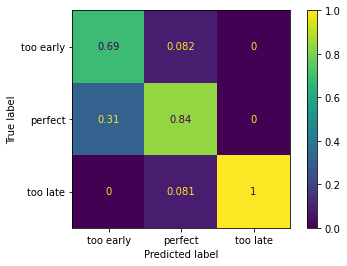

In [11]:
# rbf kernel
clf_rbf = Pipeline(
  steps=[("preprocessor", preprocessor), ("classifier", svm.SVC(kernel='rbf'))]
)
clf_rbf.fit(x_train, y_train)
# clf.score(x_test, y_test)

# Make predictions on the test set
y_pred_rbf = clf_rbf.predict(x_test)

# Model Accuracy: how often is the classifier correct?
accuracy_SVC_rbf = metrics.accuracy_score(y_test, y_pred_rbf)
# Model Precision: what percentage of positive tuples are labeled as such?
precision_SVC_rbf = metrics.precision_score(y_test, y_pred_rbf, average='weighted')
# Model Recall: what percentage of positive tuples are labelled as such?
recall_SVC_rbf = metrics.recall_score(y_test, y_pred_rbf, average='weighted')
# Model f1: 
f1_SVC_rbf = metrics.f1_score(y_test, y_pred_rbf, average='weighted')

# printout
print(f"""Results rbf SVC:
  Accuracy: {accuracy_SVC_rbf}
  Precision: {precision_SVC_rbf}
  Recall: {recall_SVC_rbf}
  F1 score: {f1_SVC_rbf}""")

# Model confusion matrix: 
confmat_SVC_rbf = metrics.confusion_matrix(y_test, y_pred_rbf, labels = ['too early', 'perfect', 'too late'], normalize='pred')
# normalize over predicted conditions calculates the part per class/ column, so if we sum over the columns we get 1. So this shows best for the model how it performs per class
cm_display_rbf = metrics.ConfusionMatrixDisplay(confmat_SVC_rbf, display_labels=['too early', 'perfect', 'too late'])

cm_display_rbf.plot()
plt.show()



# average;
# micro: Calculate metrics globally by counting the total true positives, false negatives and false positives.
# macro: Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
# weighted: Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

              precision    recall  f1-score   support

     perfect       0.93      1.00      0.97      2387
   too early       0.99      0.53      0.69       258
    too late       1.00      0.87      0.93       379

    accuracy                           0.94      3024
   macro avg       0.98      0.80      0.86      3024
weighted avg       0.95      0.94      0.94      3024

Results linear SVC:
  Accuracy: 0.9434523809523809
  Precision: 0.9468773172663689
  Recall: 0.9434523809523809
  F1 score: 0.9376525955835625


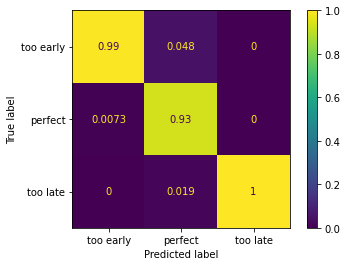

In [72]:
# linear kernel
clf_linear = Pipeline(
  steps=[("preprocessor", preprocessor), ("classifier", svm.SVC(kernel='linear'))]
)
clf_linear.fit(x_train, y_train)
# clf.score(x_test, y_test)

# Make predictions on the test set
y_pred_linear = clf_linear.predict(x_test)

print(metrics.classification_report(y_test, y_pred_linear)) 

# Model Accuracy: how often is the classifier correct?
accuracy_SVC_linear = metrics.accuracy_score(y_test, y_pred_linear)
# Model Precision: what percentage of positive tuples are labeled as such?
precision_SVC_linear = metrics.precision_score(y_test, y_pred_linear, average='weighted')
# Model Recall: what percentage of positive tuples are labelled as such?
recall_SVC_linear = metrics.recall_score(y_test, y_pred_linear, average='weighted')
# Model f1: 
f1_SVC_linear = metrics.f1_score(y_test, y_pred_linear, average='weighted')

# printout
print(f"""Results linear SVC:
  Accuracy: {accuracy_SVC_linear}
  Precision: {precision_SVC_linear}
  Recall: {recall_SVC_linear}
  F1 score: {f1_SVC_linear}""")

# Model confusion matrix: 
confmat_SVC_linear = metrics.confusion_matrix(y_test, y_pred_linear, labels = ['too early', 'perfect', 'too late'], normalize='pred')
# normalize over predicted conditions calculates the part per class/ column, so if we sum over the columns we get 1. So this shows best for the model how it performs per class
cm_display_linear = metrics.ConfusionMatrixDisplay(confmat_SVC_linear, display_labels=['too early', 'perfect', 'too late'])

cm_display_linear.plot()
plt.show()

/home/madio_linux/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Results poly SVC:
  Accuracy: 0.8237433862433863
  Precision: 0.8206260385291484
  Recall: 0.8237433862433863
  F1 score: 0.7763677884377956


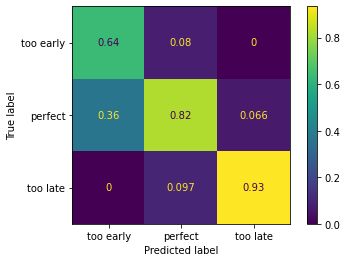

In [13]:
# poly kernel
clf_poly = Pipeline(
  steps=[("preprocessor", preprocessor), ("classifier", svm.SVC(kernel='poly'))]
)
clf_poly.fit(x_train, y_train)
# clf.score(x_test, y_test)

# Make predictions on the test set
y_pred_poly = clf_poly.predict(x_test)

# Model Accuracy: how often is the classifier correct?
accuracy_SVC_poly = metrics.accuracy_score(y_test, y_pred_poly)
# Model Precision: what percentage of positive tuples are labeled as such?
precision_SVC_poly = metrics.precision_score(y_test, y_pred_poly, average='weighted')
# Model Recall: what percentage of positive tuples are labelled as such?
recall_SVC_poly = metrics.recall_score(y_test, y_pred_poly, average='weighted')
# Model f1: 
f1_SVC_poly = metrics.f1_score(y_test, y_pred_poly, average='weighted')

# printout
print(f"""Results poly SVC:
  Accuracy: {accuracy_SVC_poly}
  Precision: {precision_SVC_poly}
  Recall: {recall_SVC_poly}
  F1 score: {f1_SVC_poly}""")

# Model confusion matrix: 
confmat_SVC_poly = metrics.confusion_matrix(y_test, y_pred_poly, labels = ['too early', 'perfect', 'too late'], normalize='pred')
# normalize over predicted conditions calculates the part per class/ column, so if we sum over the columns we get 1. So this shows best for the model how it performs per class
cm_display_poly = metrics.ConfusionMatrixDisplay(confmat_SVC_poly, display_labels=['too early', 'perfect', 'too late'])

cm_display_poly.plot()
plt.show()

/home/madio_linux/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Results sigmoid SVC:
  Accuracy: 0.71494708994709
  Precision: 0.683087558817288
  Recall: 0.71494708994709
  F1 score: 0.6867926145308579


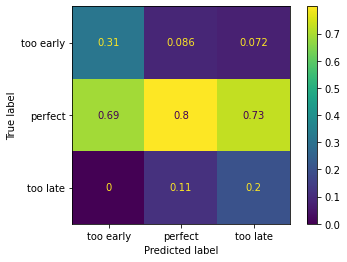

In [14]:
# sigmoid kernel
clf_sigmoid = Pipeline(
  steps=[("preprocessor", preprocessor), ("classifier", svm.SVC(kernel='sigmoid'))]
)
clf_sigmoid.fit(x_train, y_train)
# clf.score(x_test, y_test)

# Make predictions on the test set
y_pred_sigmoid = clf_sigmoid.predict(x_test)

# Model Accuracy: how often is the classifier correct?
accuracy_SVC_sigmoid = metrics.accuracy_score(y_test, y_pred_sigmoid)
# Model Precision: what percentage of positive tuples are labeled as such?
precision_SVC_sigmoid = metrics.precision_score(y_test, y_pred_sigmoid, average='weighted')
# Model Recall: what percentage of positive tuples are labelled as such?
recall_SVC_sigmoid = metrics.recall_score(y_test, y_pred_sigmoid, average='weighted')
# Model f1: 
f1_SVC_sigmoid = metrics.f1_score(y_test, y_pred_sigmoid, average='weighted')

# printout
print(f"""Results sigmoid SVC:
  Accuracy: {accuracy_SVC_sigmoid}
  Precision: {precision_SVC_sigmoid}
  Recall: {recall_SVC_sigmoid}
  F1 score: {f1_SVC_sigmoid}""")

# Model confusion matrix: 
confmat_SVC_sigmoid = metrics.confusion_matrix(y_test, y_pred_sigmoid, labels = ['too early', 'perfect', 'too late'], normalize='pred')
# normalize over predicted conditions calculates the part per class/ column, so if we sum over the columns we get 1. So this shows best for the model how it performs per class
cm_display_sigmoid = metrics.ConfusionMatrixDisplay(confmat_SVC_sigmoid, display_labels=['too early', 'perfect', 'too late'])

cm_display_sigmoid.plot()
plt.show()

### hypertuning using gridsearchCV 

explanation parameters; https://medium.com/machine-learning-101/chapter-2-svm-support-vector-machine-theory-f0812effc72
more + example; https://amagash.github.io/pages/exploration/supervised-learning/svm.html
more + example; https://www.analyticsvidhya.com/blog/2021/04/insight-into-svm-support-vector-machine-along-with-code/


In [64]:
from sklearn.model_selection import GridSearchCV 

hyper_tuning = Pipeline(
  steps=[("preprocessor", preprocessor), ("classifier", svm.SVC())]
)

# defining parameter range 
param_grid = {
  'classifier__C': [0.1, 1, 10, 100, 1000], 
	'classifier__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
	'classifier__kernel': ['rbg', 'linear', 'poly', 'sigmoid'],
  }

grid = GridSearchCV(hyper_tuning, param_grid, verbose=3) 
print(hyper_tuning.get_params().keys())
# print(y_train.dtypes)

# fitting the model for grid search 
grid.fit(x_train, y_train.values.ravel()) 

# print best parameter after tuning 
print(grid.best_params_) 


dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'classifier', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__numeric', 'preprocessor__nominal', 'preprocessor__numeric__memory', 'preprocessor__numeric__steps', 'preprocessor__numeric__verbose', 'preprocessor__numeric__imputer', 'preprocessor__numeric__scaler', 'preprocessor__numeric__imputer__add_indicator', 'preprocessor__numeric__imputer__copy', 'preprocessor__numeric__imputer__fill_value', 'preprocessor__numeric__imputer__keep_empty_features', 'preprocessor__numeric__imputer__missing_values', 'preprocessor__numeric__imputer__strategy', 'preprocessor__numeric__scaler__copy', 'preprocessor__numeric__scaler__with_mean', 'preprocessor__numeric__scaler__with_std', 'preprocessor__nominal__memory', 'preprocessor__nominal__steps', 'preprocessor__nom

/home/madio_linux/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
125 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
125 fits failed with the following error:
Traceback (most recent call last):
  File "/home/madio_linux/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/madio_linux/.local/lib/python3.10/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/madio_linux/.local/lib/python3.10/site-packages/sklearn/pipeline.py", line 475, in fit
    self._final_estimator.fit(Xt

{'classifier__C': 1000, 'classifier__gamma': 1, 'classifier__kernel': 'linear'}


              precision    recall  f1-score   support

     perfect       1.00      1.00      1.00      2387
   too early       0.99      0.98      0.98       258
    too late       0.99      0.99      0.99       379

    accuracy                           1.00      3024
   macro avg       0.99      0.99      0.99      3024
weighted avg       1.00      1.00      1.00      3024

Results poly SVC:
  Accuracy: 0.8237433862433863
  Precision: 0.8206260385291484
  Recall: 0.8237433862433863
  F1 score: 0.7763677884377956


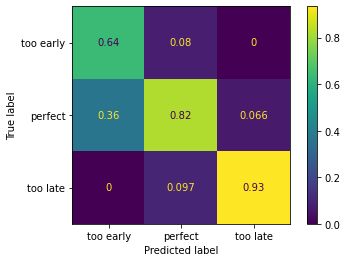

In [70]:
# print(grid.best_estimator_)

grid_predictions = grid.predict(x_test)
# print classification report 
print(metrics.classification_report(y_test, grid_predictions)) 

# Model Accuracy: how often is the classifier correct?
accuracy_SVC_poly = metrics.accuracy_score(y_test, y_pred_poly)
# Model Precision: what percentage of positive tuples are labeled as such?
precision_SVC_poly = metrics.precision_score(y_test, y_pred_poly, average='weighted')
# Model Recall: what percentage of positive tuples are labelled as such?
recall_SVC_poly = metrics.recall_score(y_test, y_pred_poly, average='weighted')
# Model f1: 
f1_SVC_poly = metrics.f1_score(y_test, y_pred_poly, average='weighted')

# printout
print(f"""Results poly SVC:
  Accuracy: {accuracy_SVC_poly}
  Precision: {precision_SVC_poly}
  Recall: {recall_SVC_poly}
  F1 score: {f1_SVC_poly}""")

# Model confusion matrix: 
confmat_SVC_poly = metrics.confusion_matrix(y_test, y_pred_poly, labels = ['too early', 'perfect', 'too late'], normalize='pred')
# normalize over predicted conditions calculates the part per class/ column, so if we sum over the columns we get 1. So this shows best for the model how it performs per class
cm_display_poly = metrics.ConfusionMatrixDisplay(confmat_SVC_poly, display_labels=['too early', 'perfect', 'too late'])

cm_display_poly.plot()
plt.show()

### complete dataset svc + checking for overfitting

c:\Users\madio\AppData\Local\r-miniconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

     perfect       0.99      1.00      0.99     36766
   too early       1.00      0.93      0.96      3930
    too late       1.00      0.98      0.99      6660

    accuracy                           0.99     47356
   macro avg       0.99      0.97      0.98     47356
weighted avg       0.99      0.99      0.99     47356

Results bigboi SVC:
  Accuracy: 0.9904552749387617
  Precision: 0.9905372748125281
  Recall: 0.9904552749387617
  F1 score: 0.9903601767480666


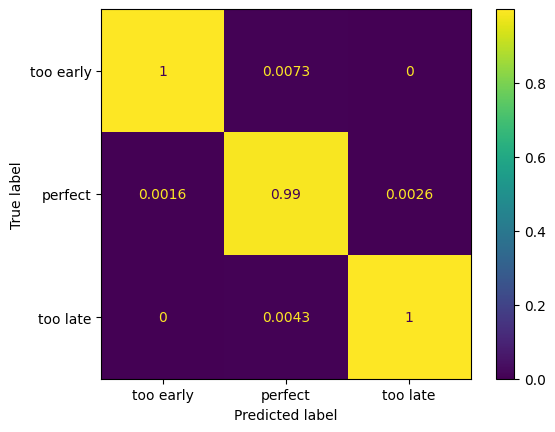

In [11]:
# 'classifier__C': 1000, 'classifier__gamma': 1, 'classifier__kernel': 'bigboi'
df_bigboi = pd.read_csv('../data/final_large_dataset_complete_15-06-2024.csv', low_memory=False)
x = df_bigboi[minimal_features]
y = df_bigboi[target_feature]

# split train test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2)
# 80% train, 20% test is generally recommended
x_train.head()

# bigboi kernel
clf_bigboi = Pipeline(
  steps=[("preprocessor", preprocessor), ("classifier", svm.SVC(kernel='linear'))]
)
clf_bigboi.fit(x_train, y_train)
# clf.score(x_test, y_test)

# Make predictions on the test set
y_pred_bigboi = clf_bigboi.predict(x_test)

print(metrics.classification_report(y_test, y_pred_bigboi)) 

# Model Accuracy: how often is the classifier correct?
accuracy_SVC_bigboi = metrics.accuracy_score(y_test, y_pred_bigboi)
# Model Precision: what percentage of positive tuples are labeled as such?
precision_SVC_bigboi = metrics.precision_score(y_test, y_pred_bigboi, average='weighted')
# Model Recall: what percentage of positive tuples are labelled as such?
recall_SVC_bigboi = metrics.recall_score(y_test, y_pred_bigboi, average='weighted')
# Model f1: 
f1_SVC_bigboi = metrics.f1_score(y_test, y_pred_bigboi, average='weighted')

# printout
print(f"""Results bigboi SVC:
  Accuracy: {accuracy_SVC_bigboi}
  Precision: {precision_SVC_bigboi}
  Recall: {recall_SVC_bigboi}
  F1 score: {f1_SVC_bigboi}""")

# Model confusion matrix: 
confmat_SVC_bigboi = metrics.confusion_matrix(y_test, y_pred_bigboi, labels = ['too early', 'perfect', 'too late'], normalize='pred')
# normalize over predicted conditions calculates the part per class/ column, so if we sum over the columns we get 1. So this shows best for the model how it performs per class
cm_display_bigboi = metrics.ConfusionMatrixDisplay(confmat_SVC_bigboi, display_labels=['too early', 'perfect', 'too late'])

cm_display_bigboi.plot()
plt.show()

In [12]:
# Cross-validation
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(clf_bigboi, x, y, cv=cv, scoring='f1_macro')
print("Cross-validation F1 scores:", cv_scores)
print("Mean cross-validation F1 score:", cv_scores.mean())
# try on training and test set to make sure it is not overfitting

c:\Users\madio\AppData\Local\r-miniconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\madio\AppData\Local\r-miniconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\madio\AppData\Local\r-miniconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\madio\AppData\Local\r-miniconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d

Cross-validation F1 scores: [0.98326368 0.97913625 0.98092034 0.98173462 0.98329849]
Mean cross-validation F1 score: 0.9816706757762914


In [ ]:
# 'classifier__C': 1000, 'classifier__gamma': 1, 'classifier__kernel': 'bigboi'
df_bigboi = pd.read_csv('../data/final_large_dataset_complete_15-06-2024.csv', low_memory=False)
x = df_bigboi[minimal_features]
y = df_bigboi[target_feature]

# split train test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2)
# 80% train, 20% test is generally recommended
x_train.head()

# bigboi kernel
clf_bigboi = Pipeline(
  steps=[("preprocessor", preprocessor), ("classifier", svm.SVC(kernel='linear'))]
)
clf_bigboi.fit(x_train, y_train)
# clf.score(x_test, y_test)

# Make predictions on the test set
y_pred_bigboi = clf_bigboi.predict(x_test)

print(metrics.classification_report(y_test, y_pred_bigboi)) 

# Model Accuracy: how often is the classifier correct?
accuracy_SVC_bigboi = metrics.accuracy_score(y_test, y_pred_bigboi)
# Model Precision: what percentage of positive tuples are labeled as such?
precision_SVC_bigboi = metrics.precision_score(y_test, y_pred_bigboi, average='weighted')
# Model Recall: what percentage of positive tuples are labelled as such?
recall_SVC_bigboi = metrics.recall_score(y_test, y_pred_bigboi, average='weighted')
# Model f1: 
f1_SVC_bigboi = metrics.f1_score(y_test, y_pred_bigboi, average='weighted')

# printout
print(f"""Results bigboi SVC:
  Accuracy: {accuracy_SVC_bigboi}
  Precision: {precision_SVC_bigboi}
  Recall: {recall_SVC_bigboi}
  F1 score: {f1_SVC_bigboi}""")

# Model confusion matrix: 
confmat_SVC_bigboi = metrics.confusion_matrix(y_test, y_pred_bigboi, labels = ['too early', 'perfect', 'too late'], normalize='pred')
# normalize over predicted conditions calculates the part per class/ column, so if we sum over the columns we get 1. So this shows best for the model how it performs per class
cm_display_bigboi = metrics.ConfusionMatrixDisplay(confmat_SVC_bigboi, display_labels=['too early', 'perfect', 'too late'])

cm_display_bigboi.plot()
plt.show()

## complete dataset

In [2]:
df_complete = pd.read_csv('../data/final_large_dataset_complete_15-06-2024.csv', low_memory=False)
df_0_900 = pd.read_csv('../data/final_large_dataset_0_900_15-06-2024.csv', low_memory=False)
df_900_2000 = pd.read_csv('../data/final_large_dataset_900_2000_15-06-2024.csv', low_memory=False)
df_2000_2500 = pd.read_csv('../data/final_large_dataset_2000_2500_15-06-2024.csv', low_memory=False)

In [3]:
final_numeric_features = ['NUMBER_CARRIAGES', 'PLAN_TURNOVER_TIME','HOUR_sin',	'HOUR_cos', 'DAY_OF_WEEK_sin',	'DAY_OF_WEEK_cos']

final_nominal_features = ['TRAINSERIE','STATION', 'COMBINE', 'SPLIT', 'ROLLINGSTOCK_TYPE', 'DALUREN', 'DRIVER_CHANGE', ]

### complete dataset untuned results

Classification Report:
               precision    recall  f1-score   support

     perfect       0.78      0.95      0.85     36720
   too early       0.15      0.02      0.04      3902
    too late       0.10      0.03      0.04      6734

    accuracy                           0.74     47356
   macro avg       0.34      0.33      0.31     47356
weighted avg       0.63      0.74      0.67     47356

Results rbf SVC:
    Accuracy: 0.7410043077962666
    Precision: 0.6278384170736139
    Recall: 0.7410043077962666
    F1 score: 0.6709955930133081


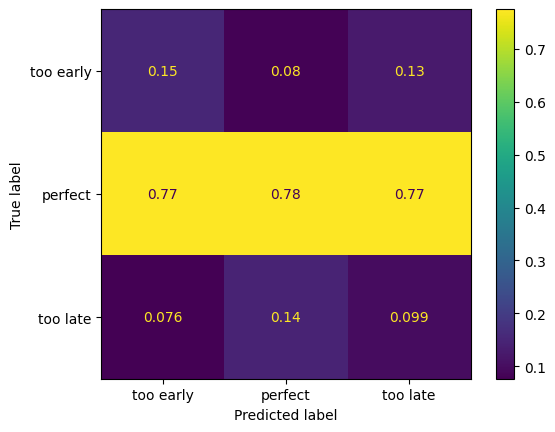

In [7]:
compl_untun_model = svc_results(df_complete, final_numeric_features, final_nominal_features, {'kernel': 'linear'})
# 148min

In [ ]:
param_grid = {
  'C': [0.1, 1, 10, 50, 100], 
	'gamma': [1, 0.1, 0.05, 0.001], 
	'kernel': ['linear'],
}

svc_tuned(df_complete, final_numeric_features, final_nominal_features, param_grid)

## split dataset

In [2]:
df_complete = pd.read_csv('../data/final_large_dataset_complete_15-06-2024.csv', low_memory=False)
df_0_900 = pd.read_csv('../data/final_large_dataset_0_900_15-06-2024.csv', low_memory=False)
df_900_2000 = pd.read_csv('../data/final_large_dataset_900_2000_15-06-2024.csv', low_memory=False)
df_2000_2500 = pd.read_csv('../data/final_large_dataset_2000_2500_15-06-2024.csv', low_memory=False)

In [3]:
# split week-model into segments and hypertune those to see if parameters are different:

# load week data
df_week_complete = pd.read_csv('../data/preprocessed_week_15-05-2024.csv', low_memory = False)
# do some additional preprocessing on it
df_week_complete = set_types(df_week_complete)
df_week_complete = days_and_hours(df_week_complete)
df_week_complete = cyclical_encoder(df_week_complete, "DAY_OF_WEEK")
df_week_complete = cyclical_encoder(df_week_complete, "HOUR")
df_week_complete = determine_daluren(df_week_complete)
df_week_complete = filter_more_outliers(df_week_complete)

# split into segments
df_week_0_900, df_week_900_2000, df_week_2000_2500 = split_data_in_segments(df_week_complete)

c:\Users\madio\Documents\UniversiteitUtrecht\Master Applied Data Science\NS thesis\my_code\preprocessing.py:223: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  temp["24-TIME"] = pd.to_datetime(temp["24-TIME"])


In [4]:
final_numeric_features = ['NUMBER_CARRIAGES', 'PLAN_TURNOVER_TIME','HOUR_sin',	'HOUR_cos', 'DAY_OF_WEEK_sin',	'DAY_OF_WEEK_cos']

final_nominal_features = ['TRAINSERIE','STATION', 'COMBINE', 'SPLIT', 'ROLLINGSTOCK_TYPE', 'DALUREN', 'DRIVER_CHANGE', ]

### split dataset + splittuned parameters

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ...............................C=0.1, kernel=linear; total time= 1.9min
[CV] END ...............................C=0.1, kernel=linear; total time= 1.9min
[CV] END ...............................C=0.1, kernel=linear; total time= 2.2min
[CV] END .................................C=1, kernel=linear; total time= 1.9min
[CV] END .................................C=1, kernel=linear; total time= 2.2min
[CV] END .................................C=1, kernel=linear; total time= 1.6min
[CV] END .................................C=5, kernel=linear; total time= 1.6min
[CV] END .................................C=5, kernel=linear; total time= 1.5min
[CV] END .................................C=5, kernel=linear; total time= 2.1min
[CV] END ................................C=10, kernel=linear; total time= 2.1min
[CV] END ................................C=10, kernel=linear; total time= 1.6min
[CV] END ................................C=10, ke

c:\Users\madio\AppData\Local\r-miniconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\madio\AppData\Local\r-miniconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\madio\AppData\Local\r-miniconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

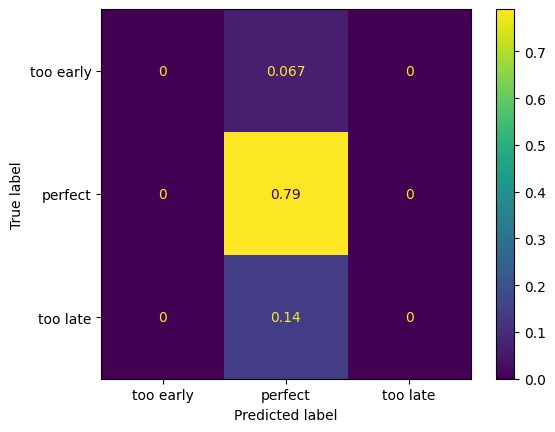

In [8]:
param_grid = {
  'C': [0.1, 1, 5, 10], 
	'kernel': ['linear'],
}


# svc_results(df_0_900, final_numeric_features, final_nominal_features, param_grid)
svc_tuned(df_week_0_900, final_numeric_features, final_nominal_features, param_grid)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ...............................C=0.1, kernel=linear; total time=  27.7s
[CV] END ...............................C=0.1, kernel=linear; total time=  20.2s
[CV] END ...............................C=0.1, kernel=linear; total time=  29.2s
[CV] END .................................C=1, kernel=linear; total time=  23.2s
[CV] END .................................C=1, kernel=linear; total time=  20.8s
[CV] END .................................C=1, kernel=linear; total time=  24.4s
[CV] END .................................C=5, kernel=linear; total time=  22.2s
[CV] END .................................C=5, kernel=linear; total time=  27.4s
[CV] END .................................C=5, kernel=linear; total time=  19.3s
[CV] END ................................C=10, kernel=linear; total time=  30.7s
[CV] END ................................C=10, kernel=linear; total time=  24.4s
[CV] END ................................C=10, ke

c:\Users\madio\AppData\Local\r-miniconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\madio\AppData\Local\r-miniconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\madio\AppData\Local\r-miniconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

Classification Report:
               precision    recall  f1-score   support

     perfect       0.78      1.00      0.88       767
   too early       0.00      0.00      0.00        95
    too late       0.00      0.00      0.00       120

    accuracy                           0.78       982
   macro avg       0.26      0.33      0.29       982
weighted avg       0.61      0.78      0.69       982

Results rbf SVC:
    Accuracy: 0.7810590631364562
    Precision: 0.6100532601075987
    Recall: 0.7810590631364562
    F1 score: 0.6850455133512429


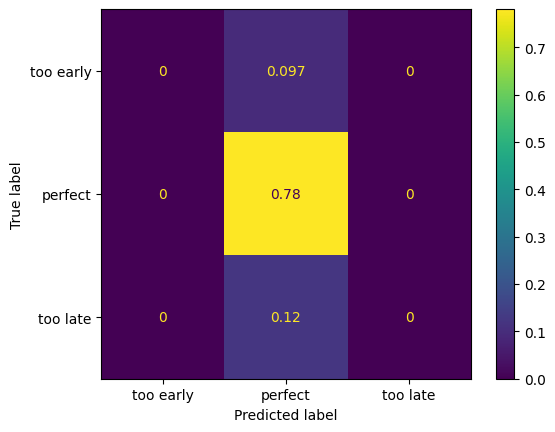

In [7]:
param_grid = {
  'C': [0.1, 1, 5, 10], 
	'kernel': ['linear'],
}


# svc_results(df_900_2000, final_numeric_features, final_nominal_features, param_grid)
svc_tuned(df_week_900_2000, final_numeric_features, final_nominal_features, param_grid)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ...............................C=0.1, kernel=linear; total time=   6.0s
[CV] END ...............................C=0.1, kernel=linear; total time=   5.6s
[CV] END ...............................C=0.1, kernel=linear; total time=   6.0s
[CV] END .................................C=1, kernel=linear; total time=   5.0s
[CV] END .................................C=1, kernel=linear; total time=   4.8s
[CV] END .................................C=1, kernel=linear; total time=   5.3s
[CV] END .................................C=5, kernel=linear; total time=   6.2s
[CV] END .................................C=5, kernel=linear; total time=   5.0s
[CV] END .................................C=5, kernel=linear; total time=   6.1s
[CV] END ................................C=10, kernel=linear; total time=   5.1s
[CV] END ................................C=10, kernel=linear; total time=   5.3s
[CV] END ................................C=10, ke

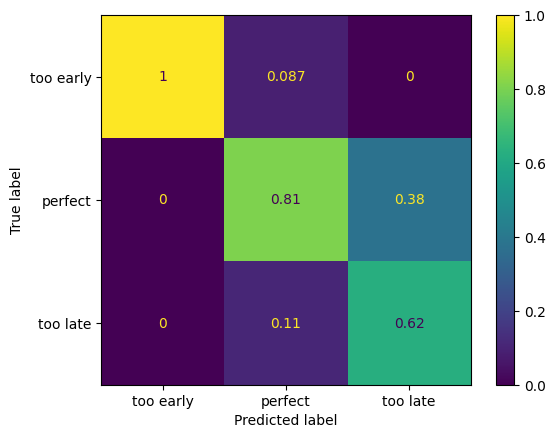

In [8]:
param_grid = {
  'C': [0.1, 1, 5,10], 
	'kernel': ['linear'],
}
# param_grid = {
#   'C': [0.1, 1, 10, 50, 100], 
# 	'gamma': [1, 0.1, 0.05, 0.001], 
# 	'kernel': ['linear'],
# }


# svc_results(df_2000_2500, final_numeric_features, final_nominal_features, param_grid)
svc_tuned(df_week_2000_2500, final_numeric_features, final_nominal_features, param_grid)

### split dataset + complete tuned parameters

Classification Report:
               precision    recall  f1-score   support

     perfect       0.79      1.00      0.88      1444
   too early       0.00      0.00      0.00       126
    too late       0.00      0.00      0.00       257

    accuracy                           0.79      1827
   macro avg       0.26      0.33      0.29      1827
weighted avg       0.62      0.79      0.70      1827

Results rbf SVC:
    Accuracy: 0.7903667214012041
    Precision: 0.6246795542984886
    Recall: 0.7903667214012041
    F1 score: 0.6978230178559087


c:\Users\madio\AppData\Local\r-miniconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\madio\AppData\Local\r-miniconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\madio\AppData\Local\r-miniconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

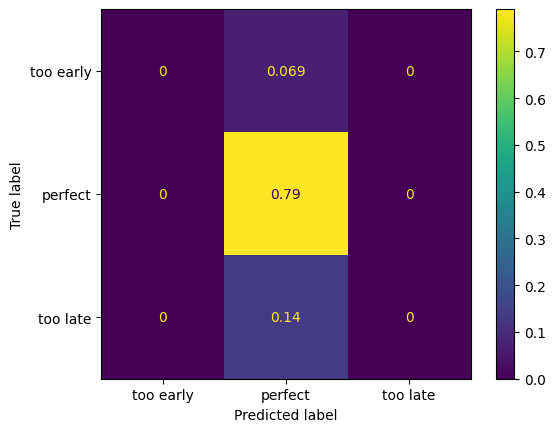

Classification Report:
               precision    recall  f1-score   support

     perfect       0.80      1.00      0.89       782
   too early       0.00      0.00      0.00        73
    too late       0.00      0.00      0.00       127

    accuracy                           0.80       982
   macro avg       0.27      0.33      0.30       982
weighted avg       0.63      0.80      0.71       982

Results rbf SVC:
    Accuracy: 0.7963340122199593
    Precision: 0.6341478590183383
    Recall: 0.7963340122199593
    F1 score: 0.7060467092471748


c:\Users\madio\AppData\Local\r-miniconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\madio\AppData\Local\r-miniconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\madio\AppData\Local\r-miniconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

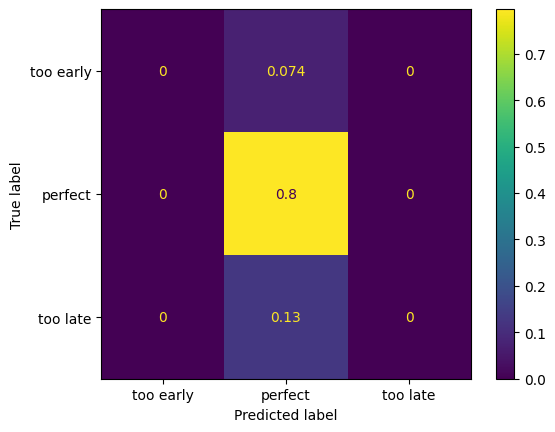

Classification Report:
               precision    recall  f1-score   support

     perfect       0.79      1.00      0.88       114
   too early       0.00      0.00      0.00         9
    too late       0.00      0.00      0.00        22

    accuracy                           0.79       145
   macro avg       0.26      0.33      0.29       145
weighted avg       0.62      0.79      0.69       145

Results rbf SVC:
    Accuracy: 0.7862068965517242
    Precision: 0.6181212841854935
    Recall: 0.7862068965517242
    F1 score: 0.692104912794568


c:\Users\madio\AppData\Local\r-miniconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\madio\AppData\Local\r-miniconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\madio\AppData\Local\r-miniconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

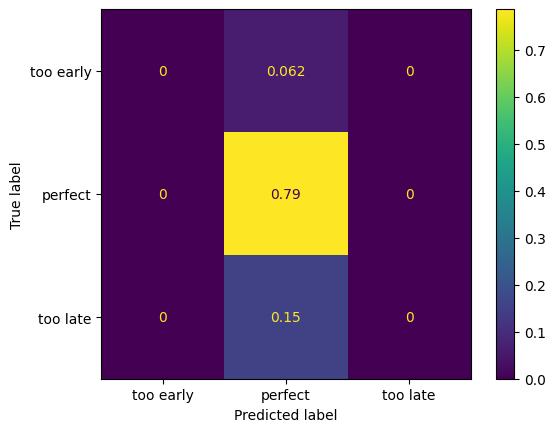

SVC(C=0.1, kernel='linear')

In [6]:
param_grid = {
  'C': [0.1, 1, 5,10], 
	'kernel': ['linear'],
}
# best_params = svc_tuned(df_week_complete, final_numeric_features, final_nominal_features, param_grid)
result_params = {'C': 0.1, 'kernel': 'linear'}

svc_results(df_week_0_900, final_numeric_features, final_nominal_features, result_params)
svc_results(df_week_900_2000, final_numeric_features, final_nominal_features, result_params)
svc_results(df_week_2000_2500, final_numeric_features, final_nominal_features, result_params)

### split tuned model whole dataset

Classification Report:
               precision    recall  f1-score   support

     perfect       0.77      0.99      0.87     19907
   too early       0.67      0.00      0.00      1946
    too late       0.35      0.02      0.04      4161

    accuracy                           0.76     26014
   macro avg       0.59      0.34      0.30     26014
weighted avg       0.69      0.76      0.67     26014

Results rbf SVC:
    Accuracy: 0.7627815791496886
    Precision: 0.6923158873609154
    Recall: 0.7627815791496886
    F1 score: 0.6683785697446177


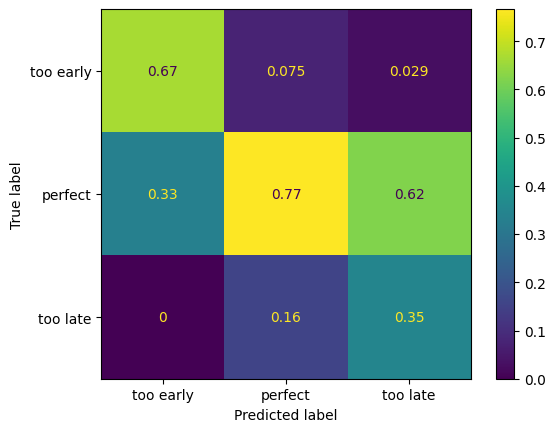

c:\Users\madio\AppData\Local\r-miniconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\madio\AppData\Local\r-miniconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\madio\AppData\Local\r-miniconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

Classification Report:
               precision    recall  f1-score   support

     perfect       0.79      0.99      0.88     14631
   too early       0.00      0.00      0.00      1742
    too late       0.10      0.01      0.01      2122

    accuracy                           0.79     18495
   macro avg       0.30      0.33      0.30     18495
weighted avg       0.64      0.79      0.70     18495

Results rbf SVC:
    Accuracy: 0.7869153825358205
    Precision: 0.6374561974327222
    Recall: 0.7869153825358205
    F1 score: 0.6979831380540508


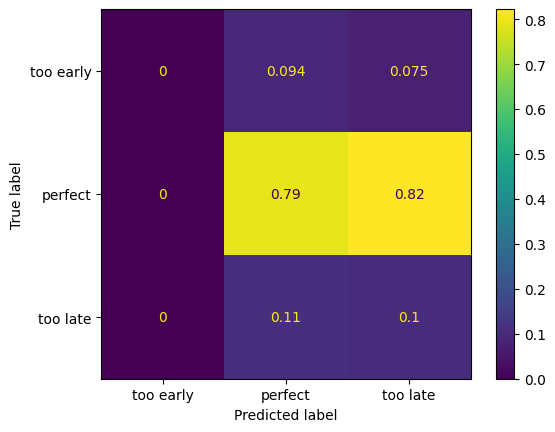

Classification Report:
               precision    recall  f1-score   support

     perfect       0.78      1.00      0.87      2221
   too early       0.67      0.01      0.01       285
    too late       0.21      0.01      0.02       342

    accuracy                           0.78      2848
   macro avg       0.55      0.34      0.30      2848
weighted avg       0.70      0.78      0.69      2848

Results rbf SVC:
    Accuracy: 0.7777387640449438
    Precision: 0.7012266699570735
    Recall: 0.7777387640449438
    F1 score: 0.6857013919740443


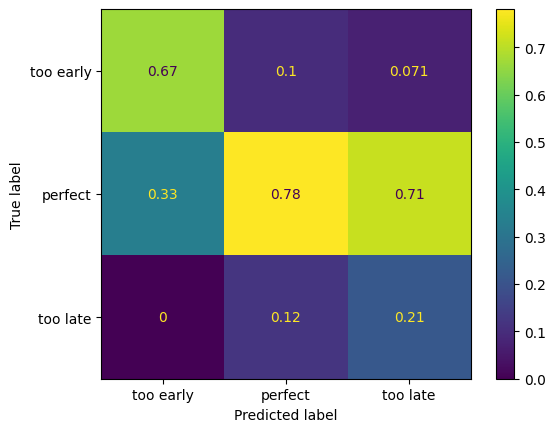

SVC(C=0.1, kernel='linear')

In [9]:
result_params = {'C': 0.1, 'kernel': 'linear'}

svc_results(df_0_900, final_numeric_features, final_nominal_features, result_params)
svc_results(df_900_2000, final_numeric_features, final_nominal_features, result_params)
svc_results(df_2000_2500, final_numeric_features, final_nominal_features, result_params)

### Split untuned model

Classification Report:
               precision    recall  f1-score   support

     perfect       0.76      0.99      0.86     19818
   too early       0.25      0.01      0.02      1878
    too late       0.39      0.01      0.01      4318

    accuracy                           0.76     26014
   macro avg       0.47      0.34      0.30     26014
weighted avg       0.66      0.76      0.66     26014

Results rbf SVC:
    Accuracy: 0.7598216345044976
    Precision: 0.6631985006978949
    Recall: 0.7598216345044976
    F1 score: 0.6615891886386186


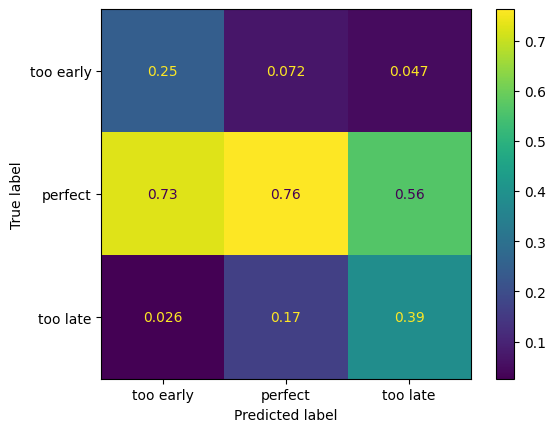

Classification Report:
               precision    recall  f1-score   support

     perfect       0.79      0.99      0.88     14621
   too early       0.40      0.00      0.00      1701
    too late       0.12      0.01      0.02      2173

    accuracy                           0.78     18495
   macro avg       0.44      0.33      0.30     18495
weighted avg       0.68      0.78      0.70     18495

Results rbf SVC:
    Accuracy: 0.7817247904839145
    Precision: 0.6757291690443529
    Recall: 0.7817247904839145
    F1 score: 0.6967210241022092


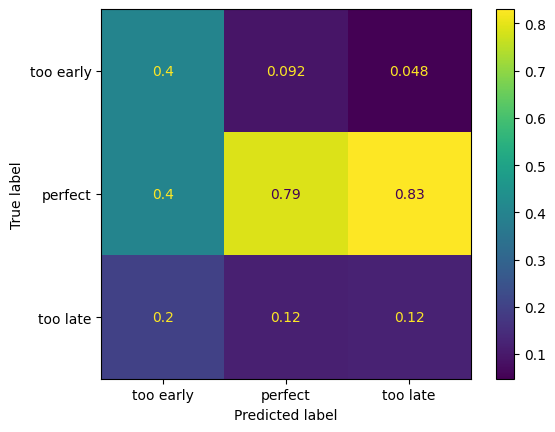

Classification Report:
               precision    recall  f1-score   support

     perfect       0.79      0.99      0.88      2252
   too early       1.00      0.01      0.02       263
    too late       0.48      0.04      0.07       333

    accuracy                           0.79      2848
   macro avg       0.76      0.35      0.32      2848
weighted avg       0.78      0.79      0.71      2848

Results rbf SVC:
    Accuracy: 0.7914325842696629
    Precision: 0.7762865566977449
    Recall: 0.7914325842696629
    F1 score: 0.7080465609337665


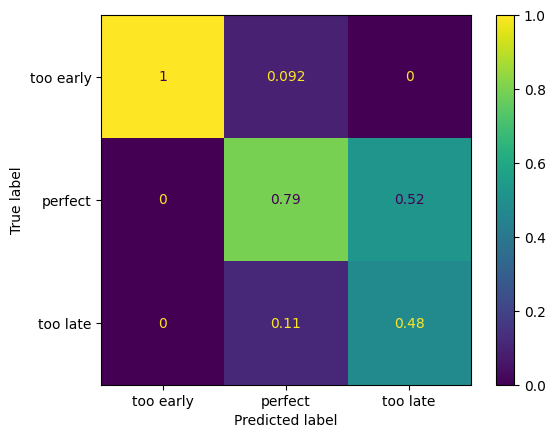

SVC(kernel='linear')

In [8]:
null_params = {'kernel': 'linear'}

svc_results(df_0_900, final_numeric_features, final_nominal_features, null_params)
svc_results(df_900_2000, final_numeric_features, final_nominal_features, null_params)
svc_results(df_2000_2500, final_numeric_features, final_nominal_features, null_params)